In [605]:
from pulp import *
import pandas as pd
from typing import List, Tuple

In [606]:
alternatives = pd.read_csv("./data/games.csv")
criteria = pd.read_csv("./data/games_criteria.csv")

In [607]:
alternatives

,title,price,positive_reviews_percentage,number_of_reviews,system_requirements,content_volume,gameplay,audio,graphics,wishlist_position
0,Nebuchadnezzar,71.99,81,1085,3,5,8,6,6,1
1,Baba Is You,53.99,98,14974,1,8,7,3,4,2
2,ELDEN RING,249.00,92,494145,9,10,8,8,8,3
3,FTL Faster Than Light,35.99,95,52971,1,6,7,9,4,4
4,Superliminal,71.99,94,18197,4,4,6,3,5,5
5,Rogue Legacy 2,114.99,90,11809,3,6,6,5,6,6
6,Last Epoch,161.99,84,15629,7,9,9,6,7,7
7,Gears Tactics,142.99,75,5873,8,5,5,4,7,8
8,Path of Exile,0.00,87,197422,7,10,8,6,7,0
9,Divinity Original Sin 2,161.99,95,139068,7,9,9,9,9,0


In [608]:
criteria

,criterion_name,criterion_type,alpha,beta,weight
0,price,cost,NaN,0.0,7
1,positive_reviews_percentage,gain,0.0,100.0,10
2,number_of_reviews,gain,0.0,NaN,5
3,system_requirements,cost,10.0,1.0,6
4,content_volume,gain,1.0,10.0,6
5,gameplay,gain,1.0,10.0,8
6,audio,gain,1.0,10.0,3
7,graphics,gain,1.0,10.0,4
8,wishlist_position,cost,NaN,NaN,6


In [609]:
criteria["weight"] /= sum(criteria["weight"])
criteria

,criterion_name,criterion_type,alpha,beta,weight
0,price,cost,NaN,0.0,0.127273
1,positive_reviews_percentage,gain,0.0,100.0,0.181818
2,number_of_reviews,gain,0.0,NaN,0.090909
3,system_requirements,cost,10.0,1.0,0.109091
4,content_volume,gain,1.0,10.0,0.109091
5,gameplay,gain,1.0,10.0,0.145455
6,audio,gain,1.0,10.0,0.054545
7,graphics,gain,1.0,10.0,0.072727
8,wishlist_position,cost,NaN,NaN,0.109091


In [610]:

def fill_alpha_beta(alternatives: pd.DataFrame, criteria: pd.DataFrame) -> pd.DataFrame:
    """
    If any criteria don't have the values for the worst (alpha) or best (beta) performance,
    make them equal to the worst/best performances attained by the alternatives on this criterion
    """
    for idx, criterion in criteria.iterrows():
        if pd.isnull(criterion["alpha"]):
            if criterion["criterion_type"] == "gain":
                criterion["alpha"] = min(alternatives[criterion["criterion_name"]])
            if criterion["criterion_type"] == "cost":
                print(criterion["criterion_name"], max(alternatives[criterion["criterion_name"]]))
                criterion["alpha"] = max(alternatives[criterion["criterion_name"]])

        if pd.isnull(criterion["beta"]):
            if criterion["criterion_type"] == "gain":
                criterion["beta"] = max(alternatives[criterion["criterion_name"]])
            if criterion["criterion_type"] == "cost":
                criterion["beta"] = min(alternatives[criterion["criterion_name"]])
        criteria.loc[idx] = criterion

In [611]:
fill_alpha_beta(alternatives, criteria)
criteria

price 249.0
wishlist_position 8


,criterion_name,criterion_type,alpha,beta,weight
0,price,cost,249.0,0.0,0.127273
1,positive_reviews_percentage,gain,0.0,100.0,0.181818
2,number_of_reviews,gain,0.0,880572.0,0.090909
3,system_requirements,cost,10.0,1.0,0.109091
4,content_volume,gain,1.0,10.0,0.109091
5,gameplay,gain,1.0,10.0,0.145455
6,audio,gain,1.0,10.0,0.054545
7,graphics,gain,1.0,10.0,0.072727
8,wishlist_position,cost,8.0,0.0,0.109091



Expected preferences from project1:
- Path of Exile > Last Epoch
- Divinity Original Sin 2 > Gears Tactics
- Portal 2 > Superliminal
- Slay the Spire > Rogue Legacy 2

Additional comparisions:
- Terraria > Elden Ring
- Slay the Spire > Nebuchadnezzar
- Elden Ring > Nebuchadnezzar
- Nebuchadnezzar > Terraria (to introduce inconsistency)


In [612]:
comparisions = [("Path of Exile", "Last Epoch", ">"), ("Divinity Original Sin 2", "Gears Tactics", ">"), ("Portal 2", "Superliminal", ">"), ("Slay the Spire", "Rogue Legacy 2", ">")]

In [613]:
def ordinal_regression_model(alternatives: pd.DataFrame, criteria: pd.DataFrame, comparisions: List[Tuple[str, str, str]], num_breakpoints: int = 0) -> LpProblem:
    alternative_names = alternatives.iloc[:, 0].tolist()
    criteria_names = criteria.iloc[:, 0].tolist()
    model = LpProblem(name="Ordinal Regression", sense=LpMinimize)

    # definig the objective function - sum of under- and over-estimation errors
    over_error_variables = LpVariable.dicts("over", alternative_names, lowBound=0)
    under_error_variables = LpVariable.dicts("under", alternative_names, lowBound=0)
    model += lpSum([x for x in list(under_error_variables.values())+list(over_error_variables.values())])

    # dictionary containing variables corresponding to values of marginal preference functions
    # at all characteristic points for every criterion
    characteristic_p_dict = dict([(name, [None] * (num_breakpoints+2)) for name in criteria_names])

    # all worst performances must be 0
    # the sum of best performances must be equal 1
    beta_variables = []
    for _, criterion in criteria.iterrows():
        criterion_name = criterion["criterion_name"]
        criterion_type = criterion["criterion_type"]
        u_a = LpVariable(name=f"{criterion_name}_u_a", lowBound=0, upBound=0)
        # we assume that weights are normalised already
        u_b = LpVariable(name=f"{criterion_name}_u_b", lowBound=criterion["weight"], upBound=criterion["weight"])
        beta_variables.append(u_b)
        model += (u_a == 0, f"u_a_{criterion_name}")
        if criterion_type == "gain":
            characteristic_p_dict[criterion_name][0] = u_a
            characteristic_p_dict[criterion_name][-1] = u_b
        if criterion_type == "cost":
            characteristic_p_dict[criterion_name][0] = u_b
            characteristic_p_dict[criterion_name][-1] = u_a


    model += LpConstraint(lpSum(beta_variables), sense=LpConstraintEQ, name="Sum of u_i(\Beta) = 1", rhs=1)

    # add monotonicity constraints for breakpoints
    for _, criterion in criteria.iterrows():
        criterion_type = criterion["criterion_type"]
        criterion_name = criterion["criterion_name"]

        # the "breakpoint" variables indicate the value of marginal value function at the breakpoint
        if criterion_type == "cost":
            previous_breakpoint = criterion["weight"]
            for i in range(num_breakpoints):
                breakpoint = LpVariable(name=f"{criterion_name}_breakpoint_{i+1}", lowBound=0)
                # +1 in index, because 0th is for the first characteristic point
                characteristic_p_dict[criterion_name][i+1] = breakpoint
                # for cost type, the marginal value function must be NON-INcreasing
                # as such, the value at the next break point must be <= the previous
                model += LpConstraint(previous_breakpoint-breakpoint, sense=LpConstraintGE, name=f"{criterion_name}_monotonicity_{i+1}")
                previous_breakpoint = breakpoint

        if criterion_type == "gain":
            previous_breakpoint = 0
            for i in range(num_breakpoints):
                breakpoint = LpVariable(name=f"{criterion_name}_breakpoint_{i+1}", lowBound=0)
                characteristic_p_dict[criterion_name][i+1] = breakpoint
                # for gain type, the function should be NON-DEcreasing
                model += LpConstraint(breakpoint-previous_breakpoint, sense=LpConstraintGE, name=f"{criterion_name}_monotonicity_{i+1}")
                previous_breakpoint = breakpoint
    # pairwise comparisions
    sense_dict = dict([(">", LpConstraintGE), ("=", LpConstraintEQ), ("<", LpConstraintLE)])
    coeffs = [1, -1, 1]
    # creating a dictionary of comprehensive value variables to avoid duplicates
    # for every performance of every alternative, its performance relative to some breakpoint must be calculated
    # here, the value at the breakpoint for the largest value of performance that is NOT GREATER than the alternative's is used as reference
    U_variables = dict([(name, lpSum([])) for name in alternative_names])
    # fraction of the range of g(a) that is spanned between two breakpoints
    bucket_width = 1/(num_breakpoints+1)
    for _, criterion in criteria.iterrows():
        criterion_name = criterion["criterion_name"]
        criterion_type = criterion["criterion_type"]
        alpha = criterion["alpha"]
        beta = criterion["beta"]
        if criterion_type == "gain":
            interval = beta - alpha
            smallest_val = alpha
        if criterion_type == "cost":
            interval = alpha - beta
            smallest_val = beta
        for _, alternative in alternatives.iterrows():
            alternative_name = alternative[0]
            performance = alternative[criterion_name]
            relative_performance = (performance - smallest_val)/interval
            characteristic_idx = int(relative_performance/bucket_width)
            absolute_perf_in_bucket = performance - smallest_val - bucket_width * interval * characteristic_idx
            # if the alternative's performance on the criterion lines up with a characterisitc point
            if absolute_perf_in_bucket == 0:
                U_variables[alternative_name] += characteristic_p_dict[criterion_name][characteristic_idx]
                continue
            # otherwise, the value should be equal to the p
            relative_perf_in_bucket = absolute_perf_in_bucket / (bucket_width * interval)
            characteristic_p_var = characteristic_p_dict[criterion_name][characteristic_idx]
            next_p_var = characteristic_p_dict[criterion_name][characteristic_idx+1]
            U_variables[alternative_name] += characteristic_p_var + relative_perf_in_bucket * (next_p_var - characteristic_p_var)
    # difference in additive value functions judged sufficient to represent strict preference
    strict_diff = 0.001
    for a, b, relation in comparisions:
        a_over = over_error_variables[a]
        a_under = under_error_variables[a]
        b_over = over_error_variables[b]
        b_under = under_error_variables[b]
        U_a = U_variables[a]
        U_b = U_variables[b]
        print(b, U_b)
        sense = sense_dict[relation]
        left = lpSum([c*x for c, x in zip(coeffs, [U_a, a_over, a_under])])
        right = lpSum([[c*x for c, x in zip(coeffs, [U_b, b_over, b_under])]])
        # transformed to compare to a constant, because that's what PuLP wants
        model += LpConstraint(left-right, sense=sense, name=f"{a}{relation}{b}", rhs=strict_diff)

    return model


In [614]:
model = ordinal_regression_model(alternatives, criteria, comparisions, 2)
model

Last Epoch 0.33333333333333337*audio_breakpoint_1 + 0.6666666666666666*audio_breakpoint_2 + 0.33333333333333337*content_volume_breakpoint_2 + 0.6666666666666666*content_volume_u_b + 0.33333333333333337*gameplay_breakpoint_2 + 0.6666666666666666*gameplay_u_b + graphics_breakpoint_2 + 0.053246071871465364*number_of_reviews_breakpoint_1 + 0.9467539281285346*number_of_reviews_u_a + 0.47999999999999965*positive_reviews_percentage_breakpoint_2 + 0.5200000000000004*positive_reviews_percentage_u_b + 0.04831325301204803*price_breakpoint_1 + 0.951686746987952*price_breakpoint_2 + system_requirements_breakpoint_2 + 0.3749999999999999*wishlist_position_breakpoint_2 + 0.6250000000000001*wishlist_position_u_a
Gears Tactics audio_breakpoint_1 + 0.6666666666666667*content_volume_breakpoint_1 + 0.3333333333333333*content_volume_breakpoint_2 + 0.6666666666666667*gameplay_breakpoint_1 + 0.3333333333333333*gameplay_breakpoint_2 + graphics_breakpoint_2 + 0.0200085853286273*number_of_reviews_breakpoint_1 + 

c:\Users\marci\AppData\Local\Programs\Python\Python310\lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Ordinal_Regression:
MINIMIZE
1*over_Baba_Is_You + 1*over_Bloons_TD_6 + 1*over_Divinity_Original_Sin_2 + 1*over_ELDEN_RING + 1*over_FTL_Faster_Than_Light + 1*over_Gears_Tactics + 1*over_Geometry_Dash + 1*over_Last_Epoch + 1*over_Nebuchadnezzar + 1*over_Path_of_Exile + 1*over_Portal_2 + 1*over_Rogue_Legacy_2 + 1*over_Slay_the_Spire + 1*over_Superliminal + 1*over_Terraria + 1*under_Baba_Is_You + 1*under_Bloons_TD_6 + 1*under_Divinity_Original_Sin_2 + 1*under_ELDEN_RING + 1*under_FTL_Faster_Than_Light + 1*under_Gears_Tactics + 1*under_Geometry_Dash + 1*under_Last_Epoch + 1*under_Nebuchadnezzar + 1*under_Path_of_Exile + 1*under_Portal_2 + 1*under_Rogue_Legacy_2 + 1*under_Slay_the_Spire + 1*under_Superliminal + 1*under_Terraria + 0
SUBJECT TO
u_a_price: price_u_a = 0

u_a_positive_reviews_percentage: positive_reviews_percentage_u_a = 0

u_a_number_of_reviews: number_of_reviews_u_a = 0

u_a_system_requirements: system_requirements_u_a = 0

u_a_content_volume: content_volume_u_a = 0

u_a_gamep

### Objective function to minimise
<!-- different convention, as we were not asked to provide that -->

In [615]:
model.objective

1*over_Baba_Is_You + 1*over_Bloons_TD_6 + 1*over_Divinity_Original_Sin_2 + 1*over_ELDEN_RING + 1*over_FTL_Faster_Than_Light + 1*over_Gears_Tactics + 1*over_Geometry_Dash + 1*over_Last_Epoch + 1*over_Nebuchadnezzar + 1*over_Path_of_Exile + 1*over_Portal_2 + 1*over_Rogue_Legacy_2 + 1*over_Slay_the_Spire + 1*over_Superliminal + 1*over_Terraria + 1*under_Baba_Is_You + 1*under_Bloons_TD_6 + 1*under_Divinity_Original_Sin_2 + 1*under_ELDEN_RING + 1*under_FTL_Faster_Than_Light + 1*under_Gears_Tactics + 1*under_Geometry_Dash + 1*under_Last_Epoch + 1*under_Nebuchadnezzar + 1*under_Path_of_Exile + 1*under_Portal_2 + 1*under_Rogue_Legacy_2 + 1*under_Slay_the_Spire + 1*under_Superliminal + 1*under_Terraria + 0

### Listing all equations

In [616]:
for c in model.constraints.items():
    print(f"{c[0]}: {c[1]}")

u_a_price: price_u_a = 0
u_a_positive_reviews_percentage: positive_reviews_percentage_u_a = 0
u_a_number_of_reviews: number_of_reviews_u_a = 0
u_a_system_requirements: system_requirements_u_a = 0
u_a_content_volume: content_volume_u_a = 0
u_a_gameplay: gameplay_u_a = 0
u_a_audio: audio_u_a = 0
u_a_graphics: graphics_u_a = 0
u_a_wishlist_position: wishlist_position_u_a = 0
Sum_of_u_i(\Beta)_=_1: audio_u_b + content_volume_u_b + gameplay_u_b + graphics_u_b + number_of_reviews_u_b + positive_reviews_percentage_u_b + price_u_b + system_requirements_u_b + wishlist_position_u_b = 1
price_monotonicity_1: -price_breakpoint_1 >= -0.12727272727272726
price_monotonicity_2: price_breakpoint_1 - price_breakpoint_2 >= 0
positive_reviews_percentage_monotonicity_1: positive_reviews_percentage_breakpoint_1 >= 0
positive_reviews_percentage_monotonicity_2: -positive_reviews_percentage_breakpoint_1 + positive_reviews_percentage_breakpoint_2 >= 0
number_of_reviews_monotonicity_1: number_of_reviews_breakpoi

### Printing the value of the objective function

In [617]:
status = model.solve()
print(f"status: {model.status}, {LpStatus[model.status]}")
print(f"Objective function value: {model.objective.value()}")

status: 1, Optimal
Objective function value: 0.0


### Listing variables and their values

In [618]:
for var in model.variables():
    print(var.name, var.value())

audio_breakpoint_1 0.0
audio_breakpoint_2 0.0
audio_u_a 0.0
audio_u_b 0.054545455
content_volume_breakpoint_1 0.0
content_volume_breakpoint_2 0.0
content_volume_u_a 0.0
content_volume_u_b 0.10909091
gameplay_breakpoint_1 0.0
gameplay_breakpoint_2 0.0
gameplay_u_a 0.0
gameplay_u_b 0.14545455
graphics_breakpoint_1 0.0
graphics_breakpoint_2 0.0
graphics_u_a 0.0
graphics_u_b 0.072727273
number_of_reviews_breakpoint_1 0.0
number_of_reviews_breakpoint_2 0.0
number_of_reviews_u_a 0.0
number_of_reviews_u_b 0.090909091
over_Baba_Is_You 0.0
over_Bloons_TD_6 0.0
over_Divinity_Original_Sin_2 0.0
over_ELDEN_RING 0.0
over_FTL_Faster_Than_Light 0.0
over_Gears_Tactics 0.0
over_Geometry_Dash 0.0
over_Last_Epoch 0.0
over_Nebuchadnezzar 0.0
over_Path_of_Exile 0.0
over_Portal_2 0.0
over_Rogue_Legacy_2 0.0
over_Slay_the_Spire 0.0
over_Superliminal 0.0
over_Terraria 0.0
positive_reviews_percentage_breakpoint_1 0.0
positive_reviews_percentage_breakpoint_2 0.0
positive_reviews_percentage_u_a 0.0
positive_revi

In [619]:
import matplotlib.pyplot as plt
import re

In [620]:
# WARNING: changing naming convenctions in the model breaks the function!!!
def marginal_value_functions(model: LpProblem, criteria: pd.DataFrame) -> dict:
    regular_expressions = []
    criteria_names = criteria.iloc[:, 0].tolist()
    criteria_var_dict = dict([(name, []) for name in criteria_names])
    functions_dict = dict([(name, []) for name in criteria_names])
    for name in criteria_names:
        regex = f"({name}_breakpoint_\d+)|({name}_u_a)|({name}_u_b)"
        regex = re.compile(regex)
        regular_expressions.append(regex)
    for var in model.variables():
        criterion_name = None
        for regex in regular_expressions:
            if not re.search(regex, var.name):
                continue
            # get everything before the last 2 underscores
            criterion_name = "_".join(var.name.split('_')[:-2])
            criteria_var_dict[criterion_name].append(var)
            break
    for _, criterion in criteria.iterrows():
        criterion_name = criterion["criterion_name"]
        criterion_type = criterion["criterion_type"]
        alpha = criterion["alpha"]
        beta = criterion["beta"]
        vars = criteria_var_dict[criterion_name]
        num_breakpoints = len(vars)-2
        interval = None
        if criterion_type == "gain":
            interval = beta - alpha
            vars.sort(key = lambda x:  x.name[-4:])
            # shift list to the left by 1
            vars.append(vars.pop(0))
            # swap u(b) with u(a)
            vars[0], vars[-1] = vars[-1], vars[0]
        if criterion_type == "cost":
            interval = alpha - beta
            vars.sort(key = lambda x: x.name[-4:])
            # shift list to the left by 1
            vars.append(vars.pop(0))

        for idx, var in enumerate(vars):
            g = min(alpha, beta) + idx * (interval/(num_breakpoints+1))
            functions_dict[criterion_name].append((g, var.value()))
    return functions_dict

In [621]:
marginal_functions = marginal_value_functions(model, criteria)

In [622]:
def draw_marginal_value_functions(functions_dict: dict, criteria: pd.DataFrame) -> None:
    y_lim = max(criteria["weight"])
    for criterion_name in functions_dict.keys():
        gs = [x[0] for x in functions_dict[criterion_name]]
        vals = [x[1] for x in functions_dict[criterion_name]]
        plt.plot(gs, vals, "-o")
        plt.xticks(gs)
        plt.ylim(-0.001, y_lim)
        plt.xlabel(f"Performance on {criterion_name}")
        plt.ylabel(f"Value function")
        for g in gs:
            plt.axvline(g, linestyle="dashed", color="grey")
        plt.show()

### Drawing plots of marginal utility functions

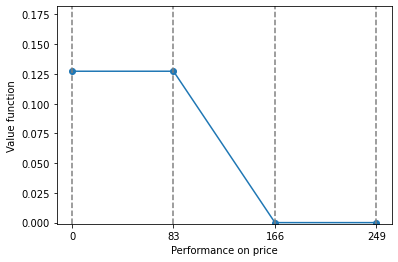

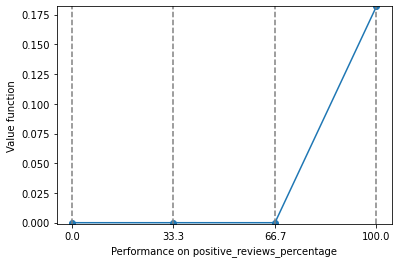

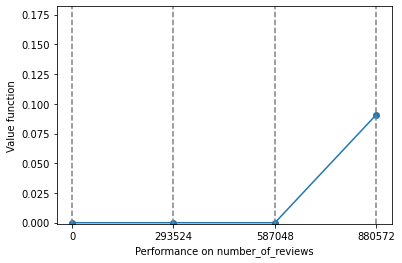

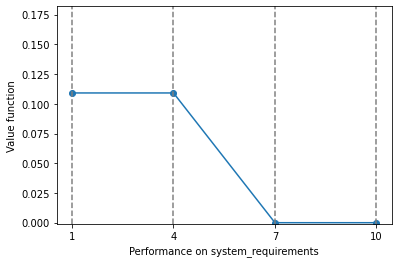

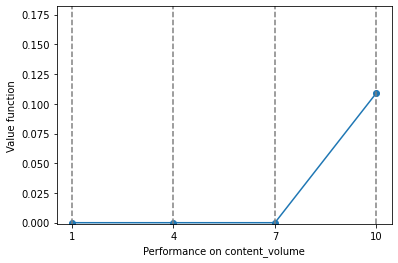

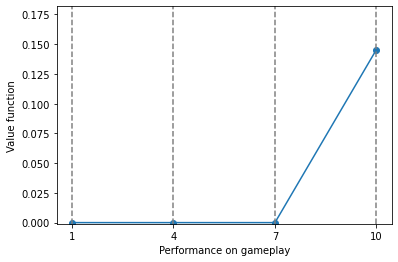

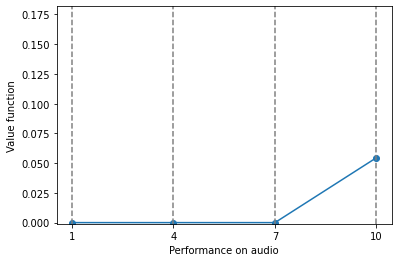

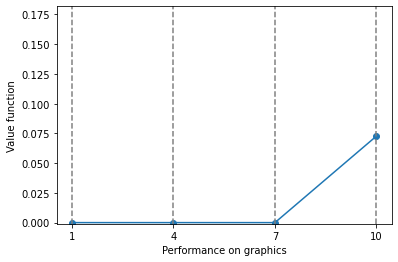

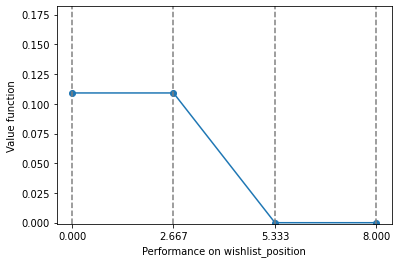

In [623]:
draw_marginal_value_functions(marginal_functions, criteria)

In [624]:
def comprehensive_value(alternative: pd.Series, criteria: pd.DataFrame, marginal_functions: dict) -> float:
    comp_val = 0
    for _, criterion in criteria.iterrows():
        criterion_name = criterion["criterion_name"]
        # criterion_type = criterion["criterion_type"]
        gs, values = zip(*marginal_functions[criterion_name])
        a_val = alternative[criterion_name]
        smallest_performance = min(criterion["alpha"], criterion["beta"])
        biggest_performance = max(criterion["alpha"], criterion["beta"])
        # I know this looks bad, but I wanted to be usre that these are handled correctly
        if a_val == smallest_performance:
            comp_val += values[0]
            continue
        if a_val == biggest_performance:
            comp_val += values[-1]
            continue
        absolute_window_width = abs(criterion["alpha"]-criterion["beta"]) / (len(gs)-1)
        for i, g in enumerate(gs):
            if a_val > g:
                continue
            diff = g - a_val
            if diff == 0:
                a_marginal = values[i]
                comp_val += a_marginal
                break
            prev_marginal = values[i-1]
            next_marginal = values[i]
            a_marginal = prev_marginal + (diff/absolute_window_width) * (next_marginal - prev_marginal)
            comp_val += a_marginal
            break
    return comp_val

In [625]:
comparisions

[('Path of Exile', 'Last Epoch', '>'),
 ('Divinity Original Sin 2', 'Gears Tactics', '>'),
 ('Portal 2', 'Superliminal', '>'),
 ('Slay the Spire', 'Rogue Legacy 2', '>')]

In [626]:
def verify_pairwise_comparisons(alternatives: pd.DataFrame, criteria: pd.DataFrame, comparisions: List[Tuple[str, str, str]], marginal_functions: dict):
    all_compatible = True
    n = alternatives.columns[0]
    for a, b, rel in comparisions:
        a_alternative = alternatives[alternatives[n]==a].iloc[0]
        b_alternative = alternatives[alternatives[n]==b].iloc[0]
        a_comp = comprehensive_value(a_alternative, criteria, marginal_functions)
        b_comp = comprehensive_value(b_alternative, criteria, marginal_functions)
        diff = a_comp - b_comp
        if rel == ">" and not diff > 0:
            print(f"{a} {rel} {b} is not satisfied: U({a}) = {a_comp}, U({b}) = {b_comp}")
            all_compatible = False
        if rel == "=" and not diff == 0:
            print(f"{a} {rel} {b} is not satisfied: U({a}) = {a_comp}, U({b}) = {b_comp}")
            all_compatible = False
        if rel == "<" and not diff < 0:
            print(f"{a} {rel} {b} is not satisfied: U({a}) = {a_comp}, U({b}) = {b_comp}")
            all_compatible = False
        # print(f"Target: {a} {rel} {b}: U({a}) = {a_comp}, U({b}) = {b_comp}")
    return all_compatible

In [627]:
verify_pairwise_comparisons(alternatives, criteria, comparisions, marginal_functions)

True